In [1]:
import geopandas as gpd
# import osmnx as ox
import censusdata
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
import math
def get_haversine_distance(point_1, point_2):
    # TODO: vectorise for fast calculation of multiple queries
    """
    Calculate the distance between any 2 points on earth given as [lon, lat]
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [point_1[0], point_1[1], 
                                                point_2[0], point_2[1]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371000 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def subset_shape_by_radius(shape, centre, radius):
    shape['centroid']=shape.centroid
    shape['in_radius']=shape.apply(lambda row: get_haversine_distance([row['centroid'].x, row['centroid'].y],
                                                                    centre)<radius, axis=1)
    return shape

In [2]:
year=2017
state_fips='06'
state_key='ca'
centre=[-122.143936, 37.468319]
radius=100000

In [71]:
bg=gpd.read_file('zip://../data/shape/cb_2019_{}_bg_500k.zip'.format(state_fips))
# bg=gpd.read_file('https://www2.census.gov/geo/tiger/TIGER{}/BG/tl_{}_{}_bg.zip'.format(year, year, state_fips))

In [72]:
bg.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [73]:
bg.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,037,800408,1,1500000US060378004081,060378004081,1,BG,2792751,1500447,"POLYGON ((-118.78754 34.02718, -118.78607 34.0..."
1,06,041,124200,4,1500000US060411242004,060411242004,4,BG,2259455,973726,"POLYGON ((-122.48698 37.89918, -122.48416 37.9..."
2,06,059,062619,4,1500000US060590626194,060590626194,4,BG,369794,343273,"POLYGON ((-117.77753 33.53639, -117.77558 33.5..."
3,06,051,000101,1,1500000US060510001011,060510001011,1,BG,2978150540,1148631,"POLYGON ((-118.94597 37.77522, -118.94348 37.7..."
4,06,093,000200,1,1500000US060930002001,060930002001,1,BG,1300052761,72751421,"POLYGON ((-122.25174 41.75805, -122.24754 41.7..."


In [74]:
# Convert to WGS84
bg = bg.to_crs("EPSG:4326")

# 15-minute communities

All metrics are calculated over the area inside a 15-minute accessible isochrone from the place of interest. For example, the metrics for block group X will be based on the community which is accessible within 15 minutes from the centroid of block group X. The mode of accessibility will generally be walking but for some metrics (eg. hospital access), driving accessibility will be used. <br>

The 15-minute communities for each block-group are computed in a pre-processing stage of the analysis. For walking accessibility, a network distance of 1200m is used as the limit (based on 4.8km/hr walkng speed). For each block-group, the following steps are carried out: <br>

- Identify the block-groups which are within 1200m straight line distance
- Of this subset, get the walking distance on the network to each block_group using the OSRM routing API. 
The results are saved as a json file where the keys are block-group IDs and the values are lists of accessible block-groups. <br>

# Compute example metrics over walkable community

## Live-Work Symmetry
#### Live-Work Balance Score
The symmetry between number of accessible jobs and local population size: <br>
$ LW = \Large\frac{min(n_{jobs}, n_{pop})}{max(n_{jobs}, n_{pop})} $

#### Live-Work Income Harmony
The symmetry in income level between workers and residents in a community. Computed as cosine simmilarity between vector of residential income categories and employed income categories<br>
$ IH = \Large\frac{I_w  \cdot I_h} {|I_w| \quad \times \quad |I_h|} $

#### Live-Work Eduction Harmony
The symmetry in education level between workers and residents in a community. Computed as cosine simmilarity between vector of residential education categories and employed education categories<br>
$ EH = \Large\frac{E_w \cdot E_h} {|E_w|  \quad \times \quad |E_h|} $


## Net-Zero Commuting
#### Walkable Access to Jobs
The number of jobs per resident in the local community

## Local Services
#### Access to Healthcare
The number of people employed in the healthcare industry in the local community, normalised by population

#### Walkable Access to hospitality
The number of people employed in the hospitality industry in the local community, normalised by population

#### Walkable Access to shopping
The number of people employed in the retail industry in the local community, normalised by population

## Social Equity
### Shannon Equitability Score
$ E_H = \Large\frac{-\sum_{j=1}^S{p_jlnp_j}}{ln(S)} $
#### Job Diversity
Shannon Equitability Score for jobs located in local community (by 2-digit NAICS codes)

#### Income Diversity
Shannon Equitability Score for income of residents of the local community

#### Education Diversity
Shannon Equitability Score for educational achievement of residents of the local community

### Load json file which maps BGs to walkable BGs

In [5]:
bg_to_walkable_bg=json.load(open('../outputs/{}/walkable_bg/bg_to_walkable_bg_osrm_{}.json'.format(
    state_fips, state_fips)))

### Get and clean the LODES Data

OD Files

In [6]:
import urllib.request as ur
from gzip import GzipFile
import pandas as pd

def get_od_data(state='ma'):
    req = ur.Request('https://lehd.ces.census.gov/data/lodes/LODES7/{}/od/{}_od_main_JT00_2017.csv.gz'.format(state, state)) 
    z_f = ur.urlopen(req)
    f = GzipFile(fileobj=z_f, mode="r")
    od = pd.read_csv(f)
    return od

def get_rac_data(state='ma'):
    req = ur.Request('https://lehd.ces.census.gov/data/lodes/LODES7/{}/rac/{}_rac_S000_JT00_2017.csv.gz'.format(state, state)) 
    z_f = ur.urlopen(req)
    f = GzipFile(fileobj=z_f, mode="r")
    rac = pd.read_csv(f)
    return rac

def get_wac_data(state='ma'):
    req = ur.Request('https://lehd.ces.census.gov/data/lodes/LODES7/{}/wac/{}_wac_S000_JT00_2017.csv.gz'.format(state, state)) 
    z_f = ur.urlopen(req)
    f = GzipFile(fileobj=z_f, mode="r")
    wac = pd.read_csv(f)
    return wac

In [7]:
# Origin-Destination (OD) File Structure
# Pos Variable Type Explanation
# 1 w_geocode Char15 Workplace Census Block Code
# 2 h_geocode Char15 Residence Census Block Code
# 3 S000 Num Total number of jobs
# 4 SA01 Num Number of jobs of workers age 29 or younger16
# 5 SA02 Num Number of jobs for workers age 30 to 5416
# 6 SA03 Num Number of jobs for workers age 55 or older16
# 7 SE01 Num Number of jobs with earnings $1250/month or less
# 8 SE02 Num Number of jobs with earnings $1251/month to $3333/month
# 9 SE03 Num Number of jobs with earnings greater than $3333/month
# 10 SI01 Num Number of jobs in Goods Producing industry sectors
# 11 SI02 Num Number of jobs in Trade, Transportation, and Utilities industry sectors
# 12 SI03 Num Number of jobs in All Other Services industry sectors
# 13 createdate Char Date on which data was created, formatted as YYYYMMDD 

In [8]:
od=get_od_data(state=state_key)
# block -> block group
od['w_block_group']=od.apply(lambda row: str(row['w_geocode'])[0:12], axis=1)
od['h_block_group']=od.apply(lambda row: str(row['h_geocode'])[0:12], axis=1)
cols_to_sum=['S000', 'SA01', 'SA02', 'SA03', 'SE01','SE02', 'SE03', 'SI01', 'SI02', 'SI03']


In [9]:
# For easy indexing save two copies of the OD matrix df
od_by_hbg_wbg=od.groupby(['h_block_group', 'w_block_group'] , as_index=True)[cols_to_sum].agg('sum')
od_by_wbg_hbg=od.groupby(['w_block_group', 'h_block_group'] , as_index=True)[cols_to_sum].agg('sum')
# also repeat the work bg as a column for doing a secondary indexing (see below)
od_by_hbg_wbg['w_block_group']=od_by_hbg_wbg.apply(lambda row: row.name[1], axis=1)

In [10]:
od_by_hbg_wbg.head()

S000  SA01  SA02  SA03  SE01  SE02  SE03  SI01  \
h_block_group w_block_group                                                   
600140010010  600140010010     31     3     3    25     5     3    23     2   
              600140030010      2     0     2     0     0     2     0     0   
              600140030040      4     1     3     0     1     3     0     0   
              600140040010      1     1     0     0     0     0     1     0   
              600140070010      1     0     1     0     0     1     0     0   

                             SI02  SI03 w_block_group  
h_block_group w_block_group                            
600140010010  600140010010      1    28  600140010010  
              600140030010      0     2  600140030010  
              600140030040      0     4  600140030040  
              600140040010      0     1  600140040010  
              600140070010      0     1  600140070010

In [11]:
# od_by_wbg_hbg.head()

RAC and WAC fles

In [12]:
rac=get_rac_data(state=state_key)
wac=get_wac_data(state=state_key)

#### Both files:
- CA: age groups
- CE: earnings groups
- CNS: NAICS
- CR: race
- CT: ethnicity
- CD: education
- CS: sex
#### Additional in WAC:
- CFA: firm age
- CFA: firm size

In [13]:
rac.head()

,h_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,...,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,createdate
0,60014001001007,49,6,30,13,6,12,31,0,0,...,3,45,4,2,8,7,26,22,27,20201110
1,60014001001008,10,2,6,2,1,1,8,0,0,...,0,10,0,0,1,4,3,3,7,20201110
2,60014001001011,6,1,4,1,3,1,2,0,0,...,0,6,0,1,2,2,0,4,2,20201110
3,60014001001013,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,1,0,20201110
4,60014001001014,11,1,4,6,3,1,7,0,0,...,0,10,1,1,0,0,9,6,5,20201110


In [14]:
rac_cols_to_sum=[col for col in rac.columns if not col in ['h_geocode', 'createdate']]
rac['h_block_group']=rac.apply(lambda row: str(row['h_geocode']).zfill(15)[0:12], axis=1)
rac_bg=rac.groupby('h_block_group', as_index=True)[rac_cols_to_sum].agg('sum')
rac_bg.head()

,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,...,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02
h_block_group,,,,,,,,,,,,,,,,,,,,,
060014001001,1448,181,806,461,197,238,1013,6,3,12,...,7,39,1341,107,117,195,358,597,723,725
060014002001,557,84,328,145,92,78,387,2,1,3,...,2,21,504,53,39,87,136,211,279,278
060014002002,550,84,350,116,77,77,396,4,1,6,...,1,24,484,66,52,70,124,220,267,283
060014003001,643,101,406,136,74,109,460,4,0,4,...,1,24,586,57,48,85,152,257,310,333
060014003002,735,128,445,162,87,130,518,6,2,5,...,1,29,633,102,56,106,178,267,358,377


In [15]:
wac_cols_to_sum=[col for col in wac.columns if not col in ['w_geocode', 'createdate']]
wac['w_block_group']=wac.apply(lambda row: str(row['w_geocode']).zfill(15)[0:12], axis=1)
wac_bg=wac.groupby('w_block_group', as_index=True)[wac_cols_to_sum].agg('sum')
wac_bg.head()

,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,...,CFA01,CFA02,CFA03,CFA04,CFA05,CFS01,CFS02,CFS03,CFS04,CFS05
w_block_group,,,,,,,,,,,,,,,,,,,,,
060014001001,917,163,468,286,173,331,413,0,0,0,...,0,0,0,0,0,0,0,0,0,0
060014002001,889,170,509,210,172,260,457,7,0,0,...,0,0,0,0,0,0,0,0,0,0
060014002002,508,176,234,98,133,254,121,0,0,0,...,0,0,0,0,0,0,0,0,0,0
060014003001,400,125,214,61,134,178,88,0,0,0,...,0,0,0,0,0,0,0,0,0,0
060014003002,439,125,229,85,114,181,144,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
all_bg_in_rac=set(rac_bg.index)
all_bg_in_wac=set(wac_bg.index)

### Functions to compute metrics for a single GEOID

#### Basic Statistics

In [17]:
def get_residents_columns_rac(bgs_in_community, full_rac, all_bg_in_rac):
    """
    returns a subset of the OD matrix
    The subset includes all rows corresponding to origins within the community
    i.e. all residents of the community
    """
    output_dict={}
    bgs_in_rac=[bg for bg in bgs_in_community if bg in all_bg_in_rac]
    if len(bgs_in_rac)>0:
        rac_subset=full_rac.loc[bgs_in_rac]
        sum_rac=rac_subset.sum()
        output_dict['total_pop_rac']=sum_rac['C000']
        output_dict['res_income_u1250_rac']=sum_rac['CE01']
        output_dict['res_income_1251-3333_rac']=sum_rac['CE02']
        output_dict['res_income_3333+_rac']=sum_rac['CE03']
        output_dict['res_age_u29_rac']=sum_rac['CE01']
        output_dict['res_age_30-54_rac']=sum_rac['CE02']
        output_dict['res_age_55+_rac']=sum_rac['CE03']
        output_dict['res_edu_no_highsch']=sum_rac['CD01']
        output_dict['res_edu_highsch']=sum_rac['CD02']
        output_dict['res_edu_some_college']=sum_rac['CD03']
        output_dict['res_edu_bach_or_higher']=sum_rac['CD04']
    else:
        print('No data for this community in RAC file: {}'.format(bgs_in_community))
    return output_dict


In [18]:
def get_workers_columns_wac(bgs_in_community, full_wac, all_bg_in_wac):
    """
    returns a subset of the OD matrix
    The subset includes all rows corresponding to origins within the community
    i.e. all residents of the community
    """
    output_dict={}
    bgs_in_wac=[bg for bg in bgs_in_community if bg in all_bg_in_wac]
    if len(bgs_in_wac)>0:
        wac_subset=full_wac.loc[bgs_in_wac]
        sum_wac=wac_subset.sum()
        output_dict['total_employ_wac']=sum_wac['C000']
        output_dict['emp_income_u1250_wac']=sum_wac['CE01']
        output_dict['emp_income_1251-3333_wac']=sum_wac['CE02']
        output_dict['emp_income_3333+_wac']=sum_wac['CE03']
        output_dict['emp_age_u29_wac']=sum_wac['CE01']
        output_dict['emp_age_30-54_wac']=sum_wac['CE02']
        output_dict['emp_age_55+_wac']=sum_wac['CE03']
        output_dict['emp_edu_no_highsch']=sum_wac['CD01']
        output_dict['emp_edu_highsch']=sum_wac['CD02']
        output_dict['emp_edu_some_college']=sum_wac['CD03']
        output_dict['emp_edu_bach_or_higher']=sum_wac['CD04']
        output_dict['emp_naics_11']=sum_wac['CNS01']
        output_dict['emp_naics_21']=sum_wac['CNS02']
        output_dict['emp_naics_22']=sum_wac['CNS03']
        output_dict['emp_naics_23']=sum_wac['CNS04']
        output_dict['emp_naics_31-33']=sum_wac['CNS05']
        output_dict['emp_naics_42']=sum_wac['CNS06']
        output_dict['emp_naics_44-45']=sum_wac['CNS07']
        output_dict['emp_naics_48-49']=sum_wac['CNS08']
        output_dict['emp_naics_51']=sum_wac['CNS09']
        output_dict['emp_naics_52']=sum_wac['CNS10']
        output_dict['emp_naics_53']=sum_wac['CNS11']
        output_dict['emp_naics_54']=sum_wac['CNS12']
        output_dict['emp_naics_55']=sum_wac['CNS13']
        output_dict['emp_naics_56']=sum_wac['CNS14']
        output_dict['emp_naics_61']=sum_wac['CNS15']
        output_dict['emp_naics_62']=sum_wac['CNS16']
        output_dict['emp_naics_71']=sum_wac['CNS17']
        output_dict['emp_naics_72']=sum_wac['CNS18']
        output_dict['emp_naics_81']=sum_wac['CNS19']
        output_dict['emp_naics_92']=sum_wac['CNS20']
        output_dict['emp_prv_firm_size_u19']=sum_wac['CFS01']
        output_dict['emp_prv_firm_size_20-49']=sum_wac['CFS02']
        output_dict['emp_prv_firm_size_50-249']=sum_wac['CFS03']
        output_dict['emp_prv_firm_size_250-499']=sum_wac['CFS04']
        output_dict['emp_prv_firm_size_500+']=sum_wac['CFS05']
        output_dict['emp_prv_firm_age_0-1']=sum_wac['CFA01']
        output_dict['emp_prv_firm_age_2-3']=sum_wac['CFA02']
        output_dict['emp_prv_firm_age_4-5']=sum_wac['CFA03']
        output_dict['emp_prv_firm_age_6-10']=sum_wac['CFA04']
        output_dict['emp_prv_firm_age_11+']=sum_wac['CFA05']
    else:
        print('No data for this community in WAC file: {}'.format(bgs_in_community))
    return output_dict

In [19]:
def get_live_and_work_columns(bgs_in_community, od_by_hbg_wbg, all_bg_in_rac):
    output_dict={}
    bgs_in_od=[bg for bg in bgs_in_community if bg in all_bg_in_wac]
    if len(bgs_in_od)>0:
        live_community=od_by_hbg_wbg.loc[bgs_in_od]
        live_work_community=live_community.loc[live_community['w_block_group'].isin(bgs_in_community)]
        sum_live_work_community=live_work_community.sum()
        output_dict['total_live_and_work_od']=sum_live_work_community['S000']
    else:
        print('No data for this community in OD file: {}'.format(bgs_in_community))
    return output_dict  

In [20]:
def get_lodes_stats(row):
    geoid=row['GEOID']
    bgs_in_community=bg_to_walkable_bg[geoid]
#     print('{}: {}'.format(geoid, bgs_in_community))
    wac_outputs=get_workers_columns_wac(bgs_in_community, full_wac=wac_bg, all_bg_in_wac=all_bg_in_wac)
    rac_outputs=get_residents_columns_rac(bgs_in_community, full_rac=rac_bg, all_bg_in_rac=all_bg_in_rac)
#     od_outputs=get_live_and_work_columns(bgs_in_community, od_by_hbg_wbg, all_bg_in_rac=all_bg_in_rac)
    for var in rac_outputs:
        row[var]=rac_outputs[var]
    for var in wac_outputs:
        row[var]=wac_outputs[var]
#     for var in od_outputs:
#         row[var]=od_outputs[var]
    return row

# Subset BGs by radius

In [76]:
bg=subset_shape_by_radius(bg, centre, radius)

<ipython-input-53-961d2cdaae69>:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shape['centroid']=shape.centroid


<AxesSubplot:>

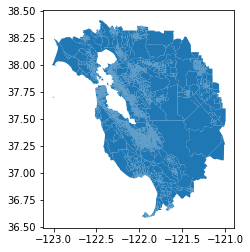

In [77]:
bg[bg['in_radius']].plot()

In [79]:
sum(bg['in_radius'])/len(bg)

0.22033971374374892

In [58]:
# bg=bg.loc[bg['in_radius']]

In [81]:
bg=bg.apply(lambda row: get_lodes_stats(row), axis=1)

No data for this community in WAC file: ['060839900000']
No data for this community in RAC file: ['060839900000']
No data for this community in WAC file: ['060375766020']
No data for this community in RAC file: ['060375766020']
No data for this community in WAC file: ['060855116082']
No data for this community in WAC file: ['061119901000']
No data for this community in RAC file: ['061119901000']
No data for this community in RAC file: ['060375734021']
No data for this community in RAC file: ['060290046043']
No data for this community in RAC file: ['060855045042']
No data for this community in WAC file: ['060759804011']
No data for this community in WAC file: ['060830029222']
No data for this community in WAC file: ['060379202001']
No data for this community in RAC file: ['060014090004']
No data for this community in RAC file: ['060375736014']
No data for this community in WAC file: ['061119800001']
No data for this community in WAC file: ['060411242001']
No data for this community in W

### Identify deserted areas which should be excluded from the metrics calculation

Plot histogram of area per resident

In [60]:
# bg=bg.merge(rac[['h_block_group','C000']], how='left', left_on='GEOID', right_on='h_block_group').rename(columns={'C000': 'pop_this_bg'})
# bg['land_per_resident']=bg['ALAND']/bg['pop_this_bg']

In [ ]:
# plt.figure(figsize=(9,9))
# _=plt.hist(bg['land_per_resident'], bins=[i*1e6 for i in range(10)])
# plt.title('Land per Resident')

In [46]:
# fig, ax=plt.subplots(1, figsize=(9,9))
# bg.plot(column='land_per_resident', ax=ax, legend=True)

In [61]:
# bg['exclude']=bg['land_per_resident']>2e6

# fig, ax=plt.subplots(1, figsize=(9,9))
# bg.loc[~bg['exclude']].plot(column='land_per_resident', ax=ax, legend=True)

In [62]:
bg.head()

,AFFGEOID,ALAND,AWATER,BLKGRPCE,COUNTYFP,GEOID,LSAD,NAME,STATEFP,TRACTCE,...,total_employ_wac,total_pop_rac,h_block_group_x,pop_this_bg,land_per_resident,exclude,centroid,in_radius,h_block_group_y,pop_this_bg
0,1500000US060411242004,2259455,973726,4,041,060411242004,BG,4,06,124200,...,258.0,514.0,060411242004,5.0,451891.0,False,POINT (-122.47645 37.89522),True,060411242004,5.0
1,1500000US060411242004,2259455,973726,4,041,060411242004,BG,4,06,124200,...,258.0,514.0,060411242004,5.0,451891.0,False,POINT (-122.47645 37.89522),True,060411242004,215.0
2,1500000US060411242004,2259455,973726,4,041,060411242004,BG,4,06,124200,...,258.0,514.0,060411242004,5.0,451891.0,False,POINT (-122.47645 37.89522),True,060411242004,19.0
3,1500000US060411242004,2259455,973726,4,041,060411242004,BG,4,06,124200,...,258.0,514.0,060411242004,5.0,451891.0,False,POINT (-122.47645 37.89522),True,060411242004,82.0
4,1500000US060411242004,2259455,973726,4,041,060411242004,BG,4,06,124200,...,258.0,514.0,060411242004,5.0,451891.0,False,POINT (-122.47645 37.89522),True,060411242004,6.0


In [82]:
len(bg)

23196

In [83]:
# bg[['geometry']].to_file('ca_100k.shp')

### Live-Work Balance Score

In [84]:
def get_live_work_score(row):
    if row['total_pop_rac'] > row['total_employ_wac']:
        return row['total_employ_wac']/row['total_pop_rac']
    else:
        return row['total_pop_rac']/row['total_employ_wac']
    
# TODO- fix function to get live_work data before the below function
def get_live_work_jaccard_score(row):
    return None

In [85]:
bg['live_work_score']=bg.apply(lambda row: get_live_work_score(row), axis=1)

Text(0.5, 1.0, 'Live-Work Score')

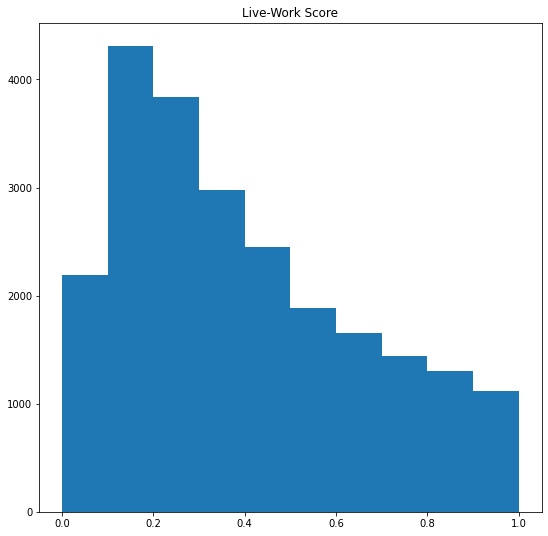

In [86]:
plt.figure(figsize=(9,9))
_=plt.hist(bg['live_work_score'])
plt.title('Live-Work Score')

In [87]:
# fig, ax=plt.subplots(1, figsize=(18,12))
# bg[~bg['exclude']].plot(ax=ax,
#         column='live_work_score',
#         legend=True)

### Demographic Harmony Scores

In [88]:
from numpy import dot
from numpy.linalg import norm

def get_income_harmony(row):
    res_income_vec=row.loc[['res_income_1251-3333_rac', 'res_income_3333+_rac', 'res_income_u1250_rac']]
    emp_income_vec=row.loc[['emp_income_1251-3333_wac', 'emp_income_3333+_wac', 'emp_income_u1250_wac']]
    a, b = res_income_vec.values, emp_income_vec.values
    return dot(a,b)/(norm(a)*norm(b))  

def get_edu_harmony(row):
    res_edu_vec=row[['res_edu_no_highsch', 'res_edu_highsch', 'res_edu_some_college', 'res_edu_bach_or_higher']]
    emp_edu_vec=row[['emp_edu_no_highsch', 'emp_edu_highsch', 'emp_edu_some_college', 'emp_edu_bach_or_higher']]
    a, b = res_edu_vec.values, emp_edu_vec.values
    return dot(a,b)/(norm(a)*norm(b)) 

In [89]:
# for col in bg.columns:
#     if 'edu' in col:
#         print(col)

In [90]:
bg['income_harmony']=bg.apply(lambda row: get_income_harmony(row), axis=1)
bg['edu_harmony']=bg.apply(lambda row: get_edu_harmony(row), axis=1)

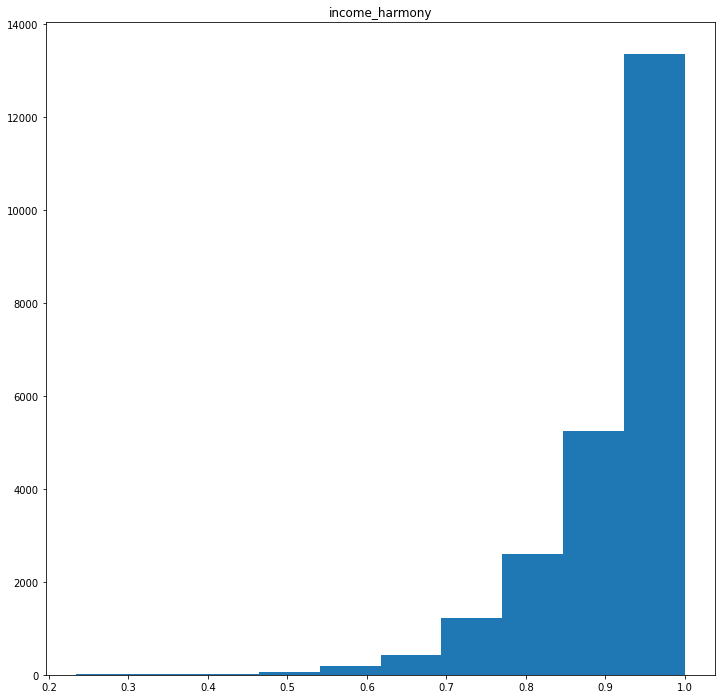

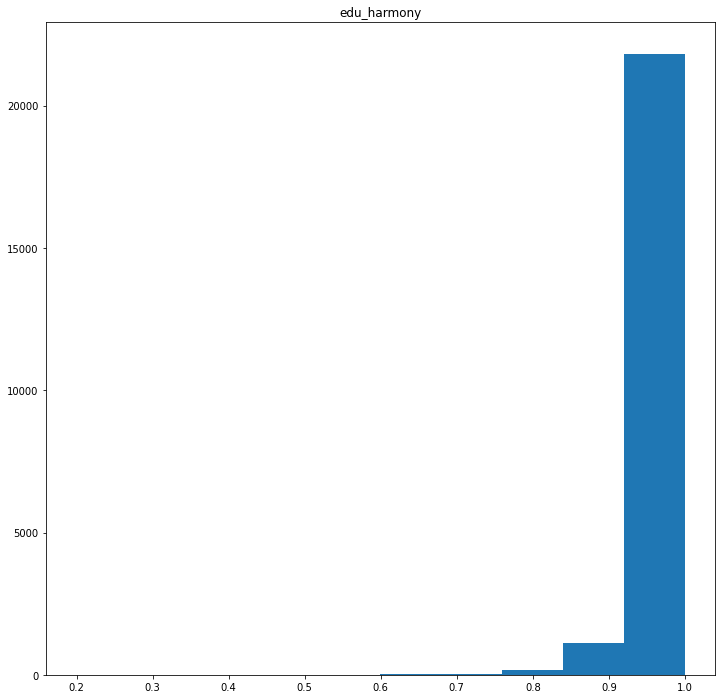

In [91]:
for col in ['income_harmony', 'edu_harmony']:
    plt.figure(figsize=(12,12))
    _=plt.hist(bg[col])
    plt.title(col)
    
#     fig, ax=plt.subplots(1, figsize=(18,12))
#     bg[~bg['exclude']].plot(ax=ax,
#             column=col,
#             legend=True)
#     ax.set_title(col)

### Access to Amenities Scores

In [92]:
def get_access_scores(row):
    output_dict={}
    row['healthcare_access']=row['emp_naics_62']/row['total_pop_rac']
    row['hospitality_access']=row['emp_naics_72']/row['total_pop_rac']
    row['shopping_access']=row['emp_naics_44-45']/row['total_pop_rac']
    row['jobs_access']=row['total_employ_wac']/row['total_pop_rac']
    return row

In [93]:
bg=bg.apply(lambda row: get_access_scores(row), axis=1)

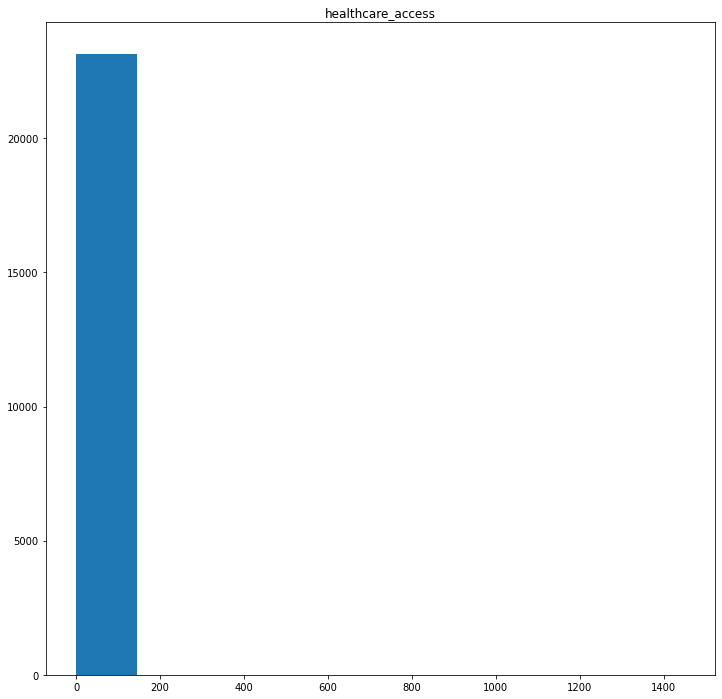

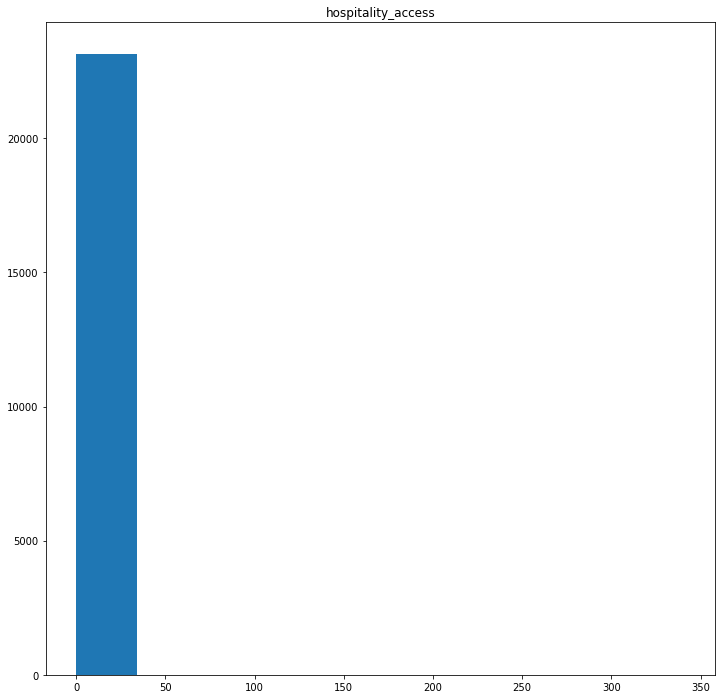

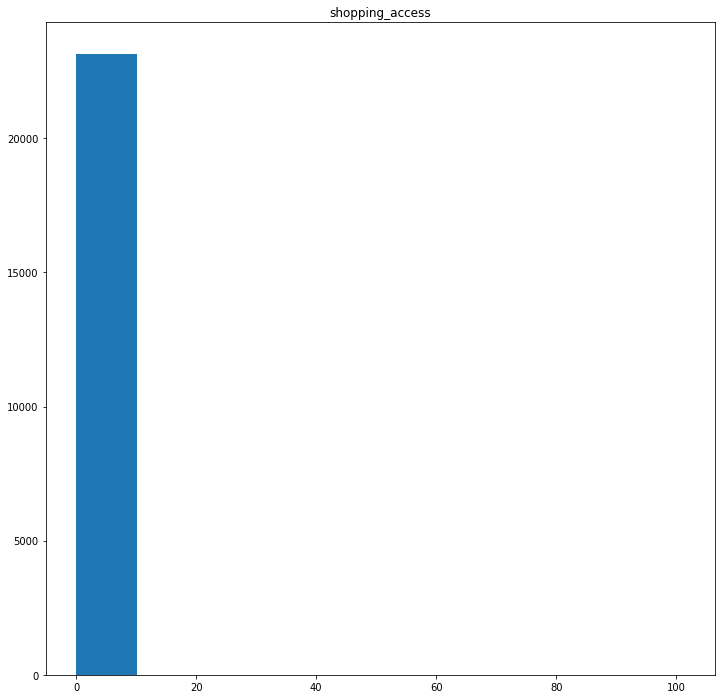

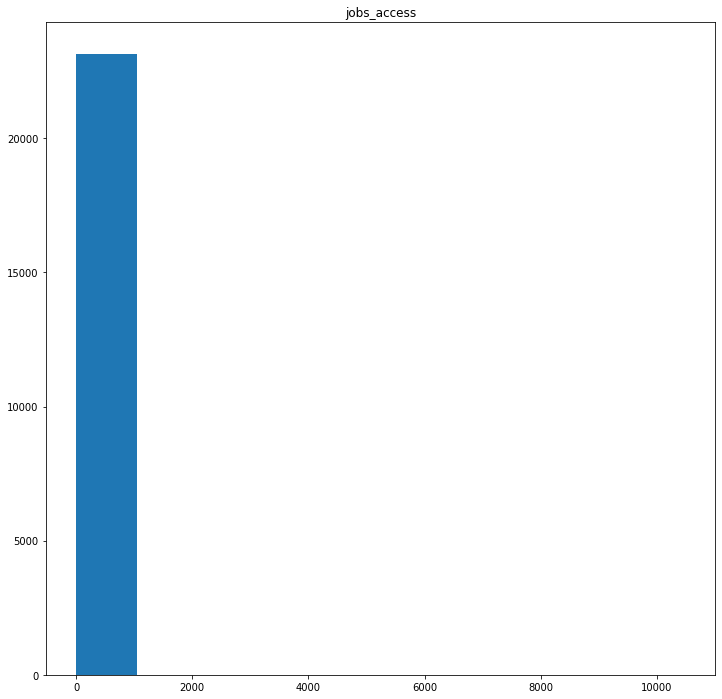

In [94]:
for col in ['healthcare_access', 'hospitality_access', 'shopping_access', 'jobs_access']:
    plt.figure(figsize=(12,12))
    _=plt.hist(bg[col])
    plt.title(col)
    
#     fig, ax=plt.subplots(1, figsize=(18,12))
#     bg[~bg['exclude']].plot(ax=ax,
#             column=col,
#             legend=True)
#     ax.set_title(col)

### Diversity Scores

In [95]:
import math
def shannon_equitability_score(species_counts):
    diversity=0
    pop_size=sum(species_counts)
    if ((len(species_counts)>1) and (pop_size>0)):        
        for count in species_counts:
            pj=count/pop_size
            if not pj==0:
                diversity+= -pj*math.log(pj)
        equitability=diversity/math.log(len(species_counts))
        return equitability
    else:
        return float('nan')
    
def get_diversity_scores(row):
    edu_group_cols=['res_edu_no_highsch', 'res_edu_highsch', 'res_edu_some_college', 'res_edu_bach_or_higher']
    income_group_cols=['res_income_1251-3333_rac', 'res_income_3333+_rac', 'res_income_u1250_rac']
    emp_group_cols=[col for col in row.keys() if 'emp_naics' in col]
    
    income_group_counts=[row[col] for col in income_group_cols]
    edu_group_counts=[row[col] for col in emp_group_cols]
    emp_group_counts=[row[col] for col in emp_group_cols]
    
    row['income_diversity']=shannon_equitability_score(income_group_counts)
    row['education_diversity']=shannon_equitability_score(edu_group_counts)
    row['employment_diversity']=shannon_equitability_score(emp_group_counts)
    return row
    

In [96]:
bg=bg.apply(lambda row: get_diversity_scores(row), axis=1)

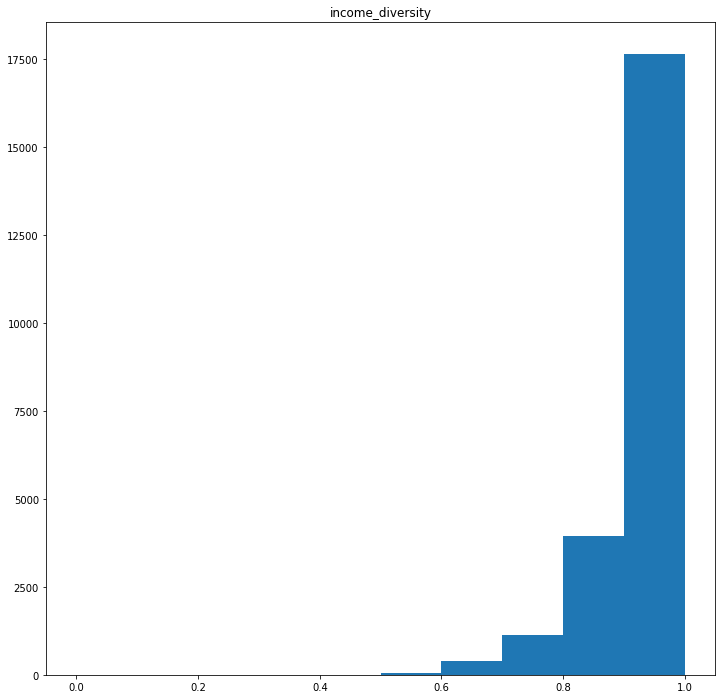

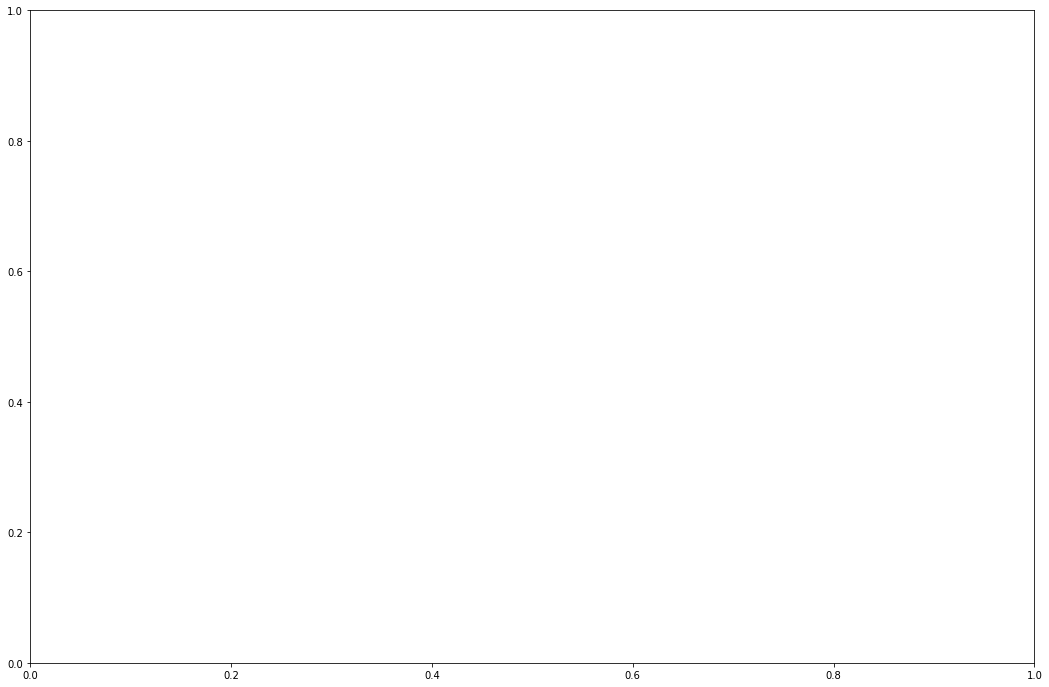

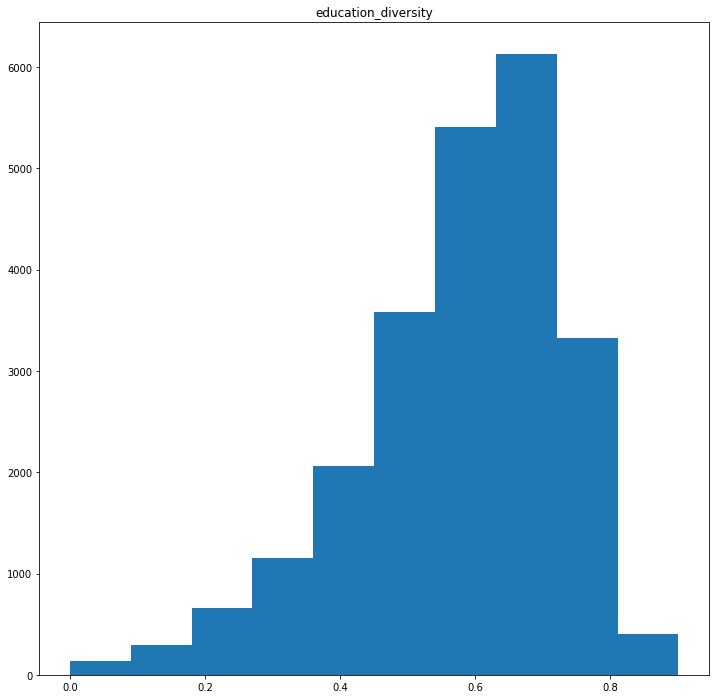

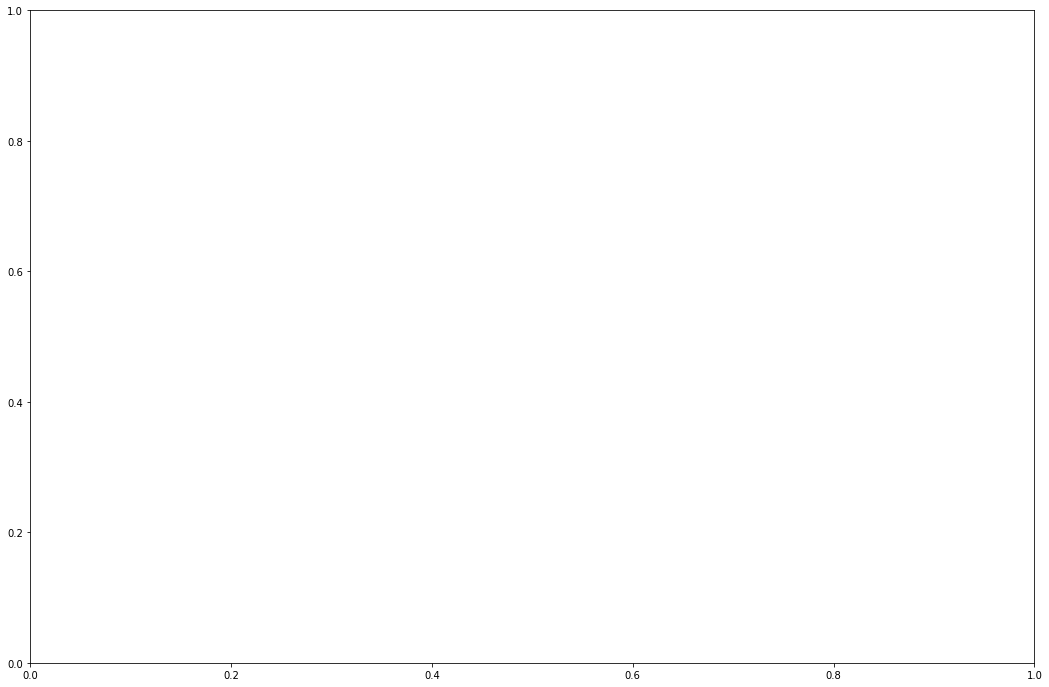

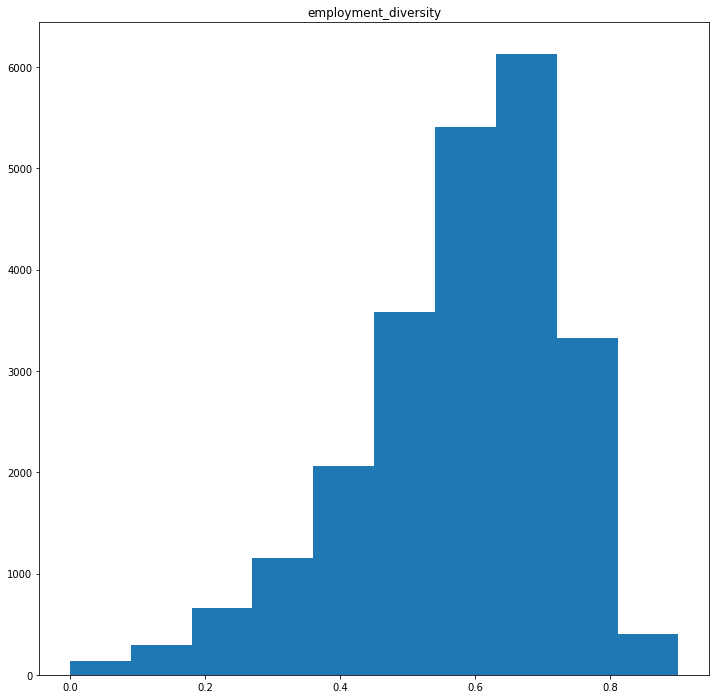

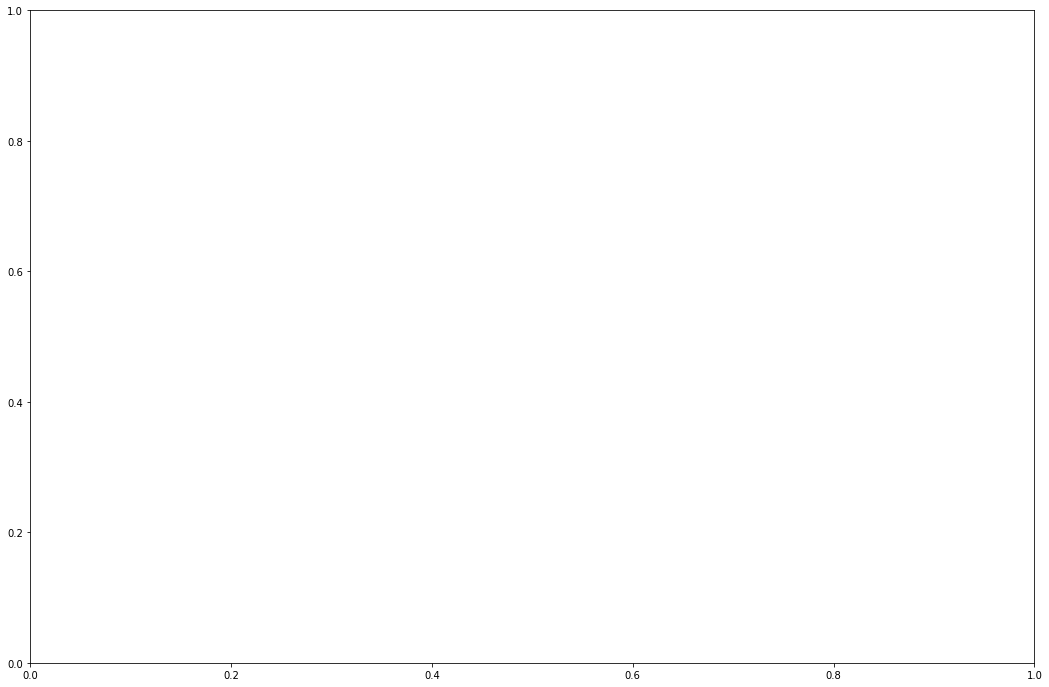

In [97]:
for col in ['income_diversity', 'education_diversity', 'employment_diversity']:
    plt.figure(figsize=(12,12))
    _=plt.hist(bg[col])
    plt.title(col)
    
    fig, ax=plt.subplots(1, figsize=(18,12))
#     bg[~bg['exclude']].plot(ax=ax,
#             column=col,
#             legend=True)
#     ax.set_title(col)


# Raw Indicators -> Percentiles

In [98]:
import numpy as np
import statsmodels
from statsmodels.distributions.empirical_distribution import ECDF

In [99]:
score_groups={'Live-Work Symmetry':['live_work_score', 'income_harmony', 'edu_harmony'],
              'Local Services': ['healthcare_access','hospitality_access', 'shopping_access'],
              'Net-Zero Commuting': ['jobs_access'],
              'Diversity': ['income_diversity', 'education_diversity', 'employment_diversity']}
              

In [100]:
all_raw_score_cols=set()
for group in score_groups:
    all_raw_score_cols.update(score_groups[group])
print(all_raw_score_cols)

for col in all_raw_score_cols:
    ecdf=ECDF(bg[col])
    bg[col+'_pct']=ecdf(bg[col])
    bg.loc[bg[col].isnull(), col+'_pct']=float('nan')
    
for group in score_groups:
    pct_cols_this_group=['{}_pct'.format(col) for col in score_groups[group]]
    bg[group]=bg[pct_cols_this_group].mean(axis=1)

{'jobs_access', 'education_diversity', 'hospitality_access', 'live_work_score', 'shopping_access', 'income_diversity', 'employment_diversity', 'income_harmony', 'edu_harmony', 'healthcare_access'}


In [101]:
bg[[group for group in score_groups]]

,Live-Work Symmetry,Local Services,Net-Zero Commuting,Diversity
0,0.468069,0.670834,0.830531,0.318647
1,0.596281,0.331106,0.578893,0.408935
2,0.407254,0.873311,0.864071,0.364043
3,0.366428,0.304650,0.308717,0.742197
4,0.854630,0.434112,0.795137,0.496709
...,...,...,...,...
23191,0.352460,0.693367,0.887653,0.317009
23192,0.113453,0.197462,0.067081,0.420690
23193,0.510289,0.184874,0.839714,0.382465
23194,0.573533,0.886187,0.906406,0.661019


# Final Individual Scores

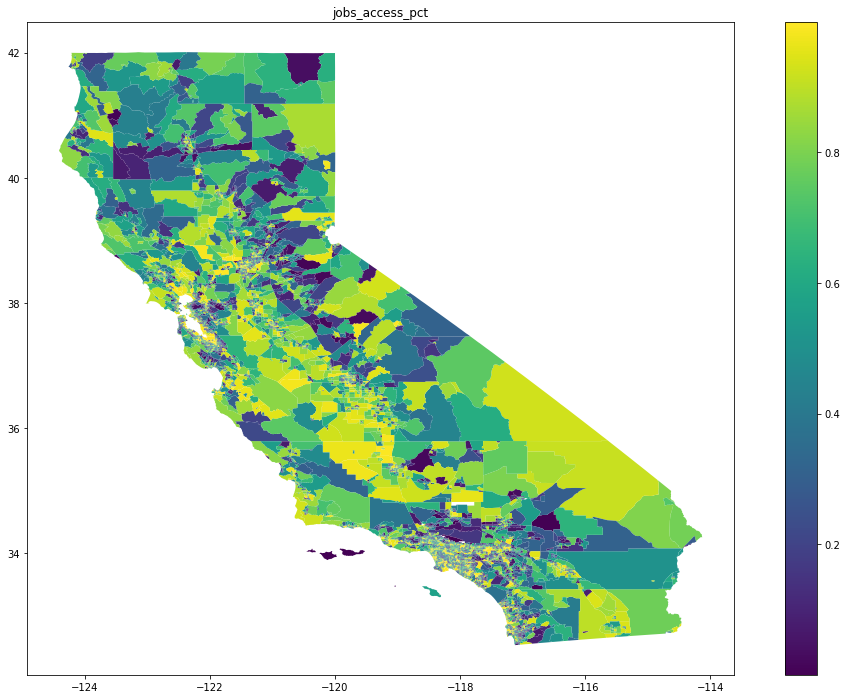

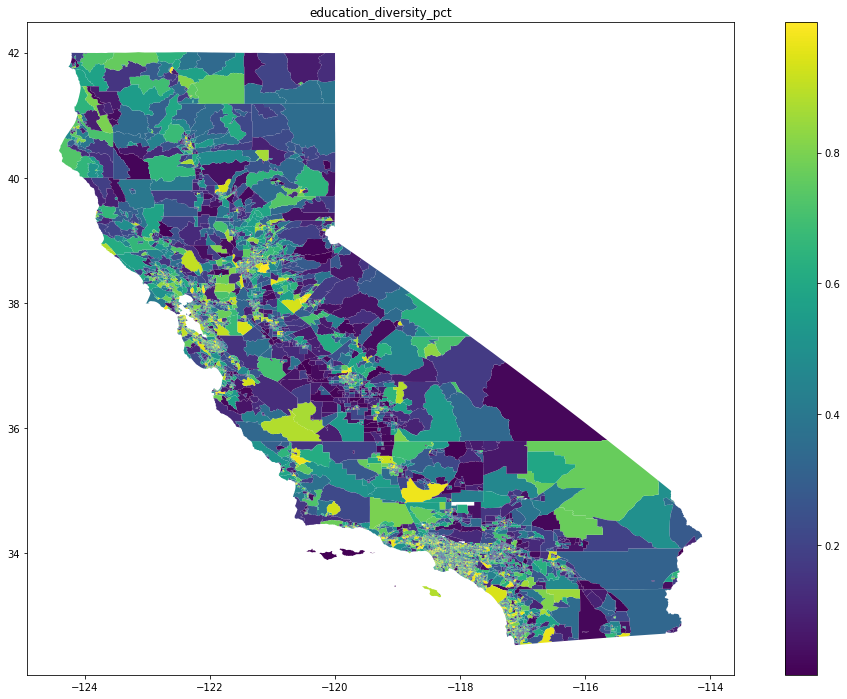

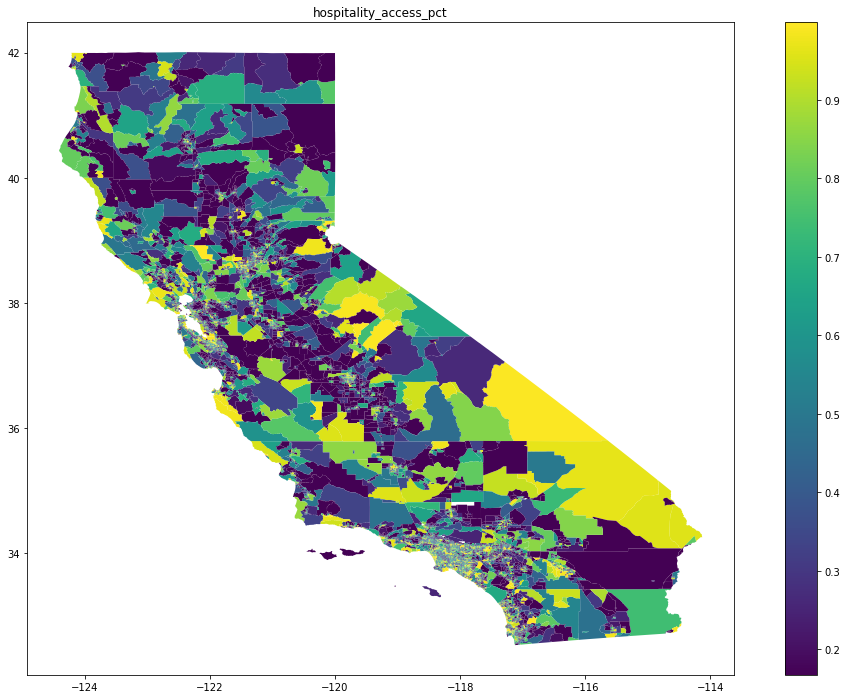

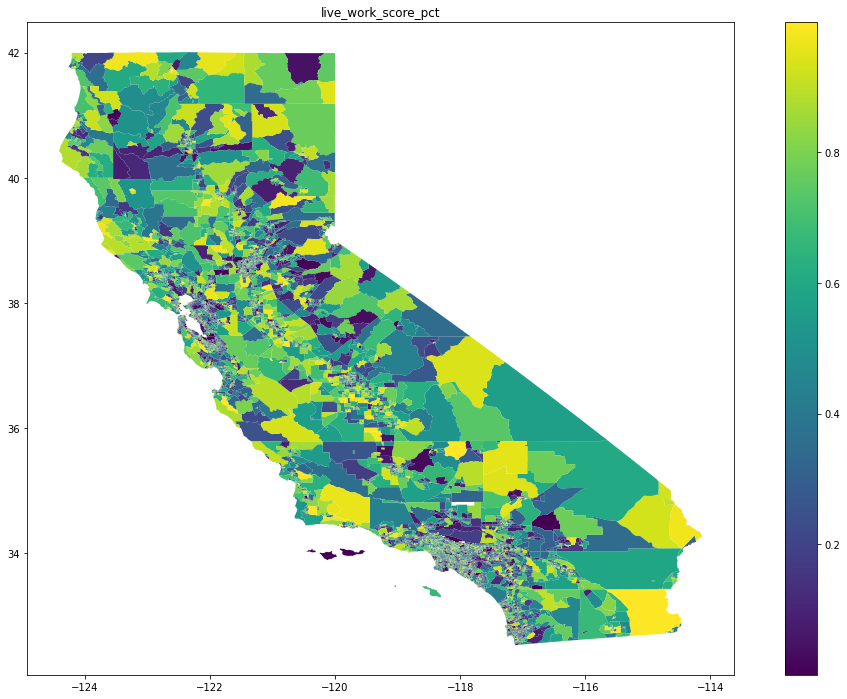

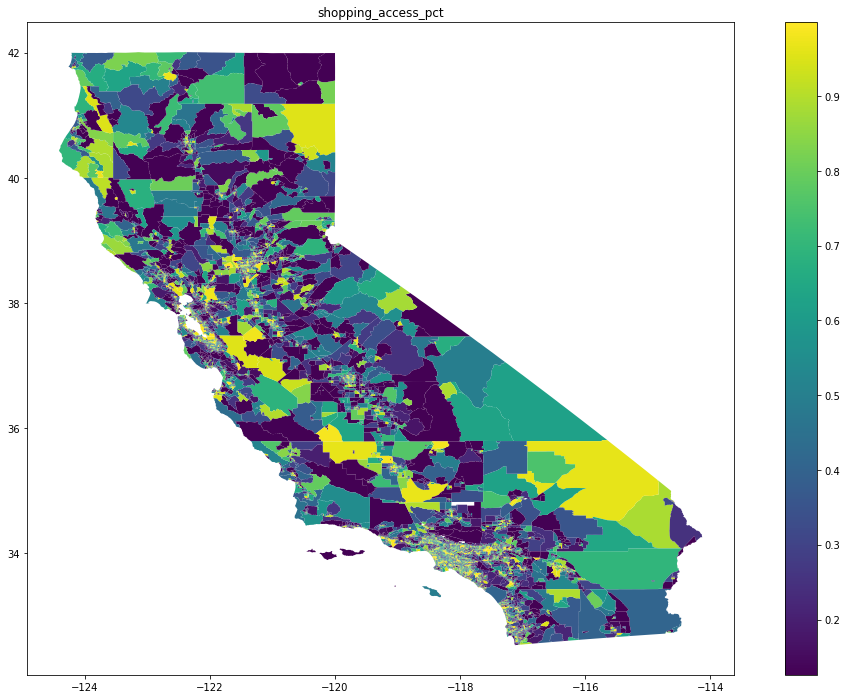

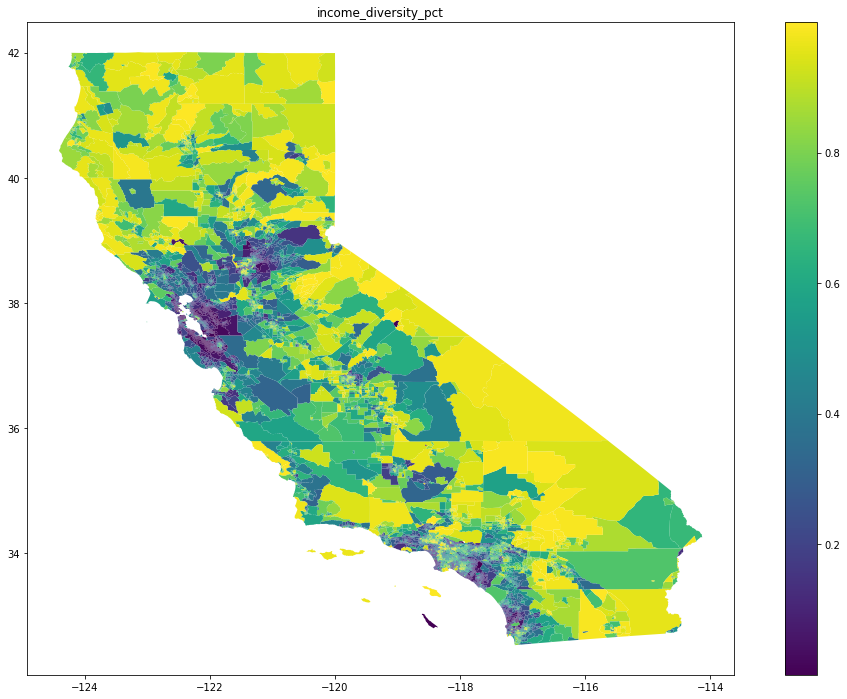

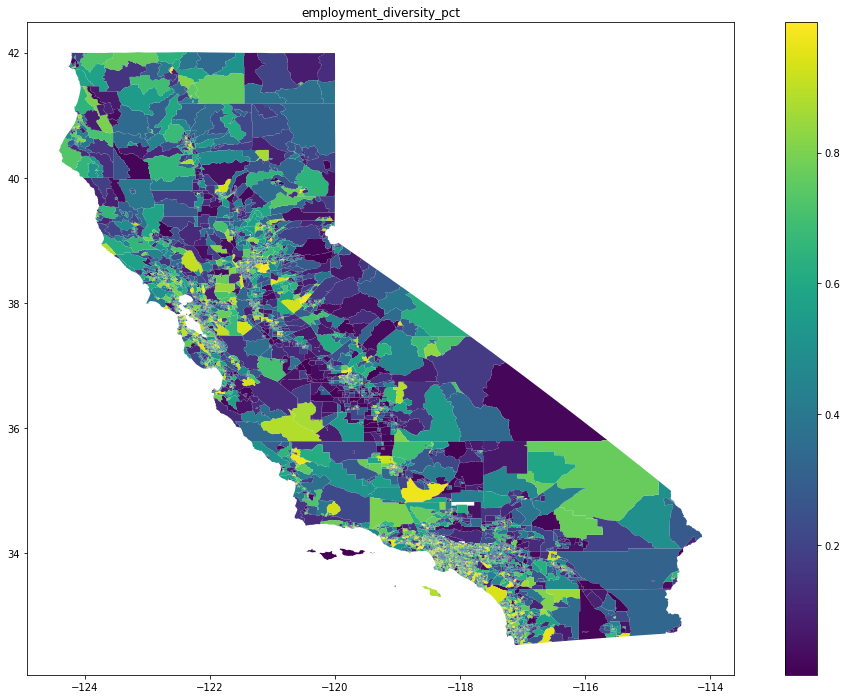

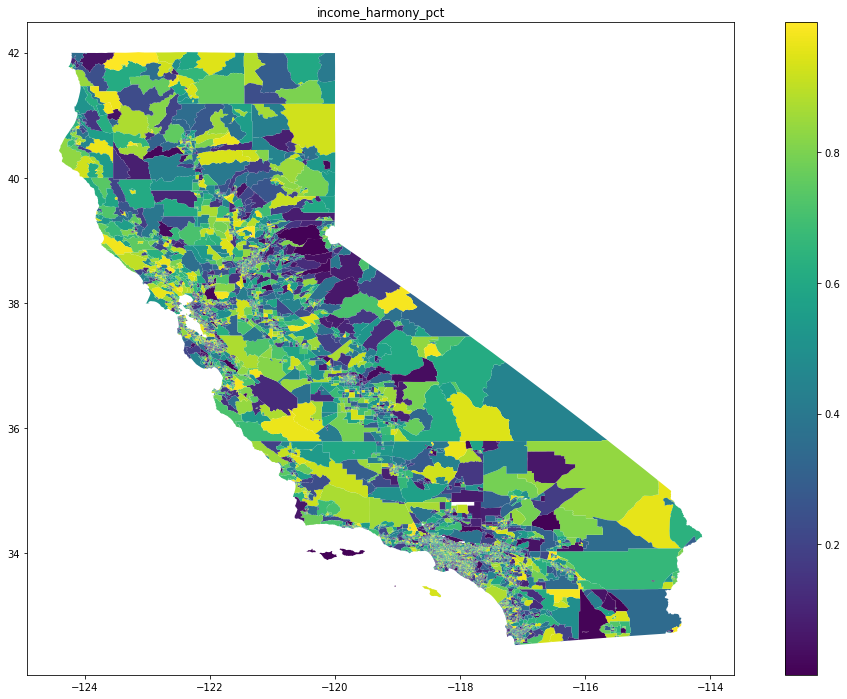

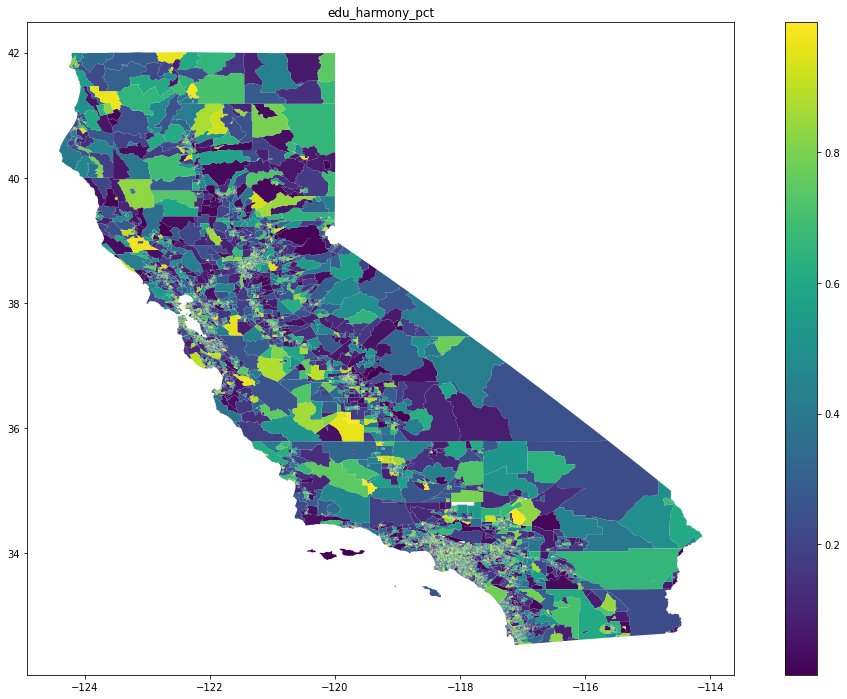

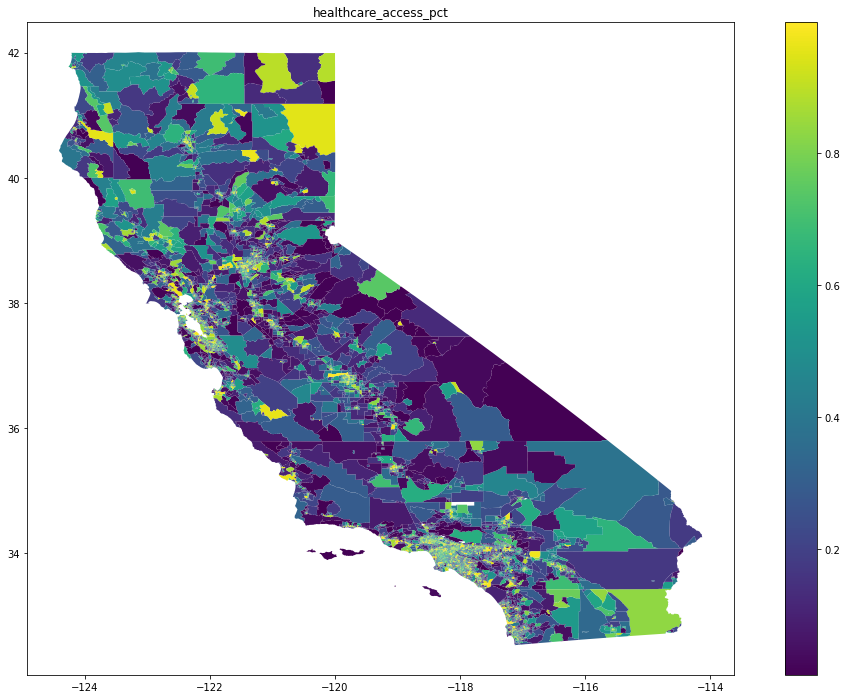

In [103]:
for score in all_raw_score_cols:
    col=score+'_pct'
    fig, ax=plt.subplots(1, figsize=(18,12))
    bg.plot(ax=ax,
            column=col,
            legend=True)
    ax.set_title(col)

# Final Grouped Scores

In [ ]:
for group in score_groups:
    fig, ax=plt.subplots(1, figsize=(18,12))
    bg.plot(ax=ax,
            column=group,
            legend=True)
    ax.set_title(group)

In [105]:
all_final_scores= [
#     sg for sg in score_groups] + [
    score+'_pct' for score in all_raw_score_cols]

In [108]:
save_cols=['GEOID','geometry']+all_final_scores
bg[save_cols].to_file('../outputs/metrics/{}/metrics_{}/metrics_{}.shp'.format(state_fips, state_fips, state_fips))
bg[save_cols].to_file('../outputs/metrics/{}/metrics_{}.geojson'.format(state_fips, state_fips), 
                      driver='GeoJSON')